In [2]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models import vgg16
from HSI_class import HSI

import zeroPadding


In [3]:
dataset_path = r"C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets"

datasets = []

i = 0
for filename in os.listdir(dataset_path):
    if i > 0:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        datasets.append(hsi)
    i += 1

Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM01.mat


In [4]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    gt= hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {gt.shape}")

    indices0 = np.argwhere(gt == 0)
    indices1 = np.argwhere(gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    return matrix, gt

In [5]:
class VGG16_HSI(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16_HSI, self).__init__()

         # Custom Convolutional Layer: Process 9x9x224 input
        self.pre_conv = nn.Sequential(
            nn.Conv2d(in_channels=224, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((1, 1))  # Reduce to (256, 1, 1)
        )

        # Fully Connected Layer to reshape to (64, 56, 56)
        self.fc = nn.Linear(256 * 1 * 1, 64 * 56 * 56)

        # Load VGG-16 Model
        self.encoder = vgg16(pretrained=False)

        # Remove first VGG-16 conv layer
        self.encoder.features = nn.Sequential(*list(self.encoder.features.children())[1:])

        # Modify classifier to output 2 classes
        self.encoder.classifier[6] = nn.Linear(4096, 2)

    def forward(self, x):
        # print(f'before {x.shape}')
        x = self.pre_conv(x)  # Process hyperspectral input
        x = x.view(x.size(0), -1)  # Flatten

        # print(f'after preconv {x.shape}')
        x = self.fc(x)  # Fully connected layer
        # print(f'after fc {x.shape}')
        # Reshape to (batch_size, 64, 56, 56) before passing to VGG
        x = x.view(x.size(0), 64, 56, 56)
        # print(f'after reshape, before vgg second layer {x.shape}')

        x = self.encoder.features(x)  # Pass to VGG-16
        x = self.encoder.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.encoder.classifier(x)  # Final classification layer

        return x

In [6]:
def predict_batch(model, batch_input, device):
    model.eval()
    batch_input = batch_input.to(device)

    with torch.no_grad():
        output = model(batch_input)

    predicted_classes = torch.argmax(output, dim=1).cpu().numpy()
    confidences = torch.nn.functional.softmax(output, dim=1)
    confidences = confidences[range(len(predicted_classes)), predicted_classes].cpu().numpy()

    return predicted_classes, confidences

In [20]:
from itertools import islice
def patch_generator(matrix, gt, half_patch, expected_shape):
    size_x, size_y = matrix.shape[0], matrix.shape[1]
    for x in range(half_patch, size_x - half_patch):
        for y in range(half_patch, size_y - half_patch):
            true_label = gt[x - half_patch][y - half_patch]

            selected_rows = matrix[x:x + 2 * half_patch + 1, :]
            testing_patch = selected_rows[:, y:y + 2 * half_patch + 1]

            if testing_patch.shape != expected_shape:
                continue

            patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
            patch_tensor = patch_tensor.unsqueeze(0).permute(0, 3, 1, 2)

            yield patch_tensor, true_label

def batcher(generator, batch_size):
    while True:
        batch = list(islice(generator, batch_size))
        if not batch:
            break
        yield batch

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64  # You can change this depending on your GPU capacity

model_path = r"C:\Users\Asus TUF\Documents\code\TA\simsiam\simsiam\models\best_model\checkpoint_0010.pth.tar"
model_name = model_path.split('\\')[-1]

print(f"Creating model {model_name}...")
saved_model = VGG16_HSI().to(device)
checkpoint = torch.load(model_path, map_location=device)
saved_model.load_state_dict(checkpoint['state_dict'])
print("Model loaded and moved to device")

patch_size = 9
half_patch = patch_size // 2

scores = []

results = []

for dataset in range(len(datasets)):
    print(f"Processing dataset {dataset}")
    matrix, gt = testWithDataset(dataset)

    size_x, size_y = matrix.shape[0], matrix.shape[1]
    total = gt.shape[0] * gt.shape[1]
    correct = 0

    expected_patch_shape = (2 * half_patch + 1, 2 * half_patch + 1, matrix.shape[2])
    gen = patch_generator(matrix, gt, half_patch, expected_patch_shape)

    patch_count = (size_x - 2 * half_patch) * (size_y - 2 * half_patch)
    batch_gen = batcher(gen, batch_size)

    # For storing prediction results
    pred_matrix = np.full(gt.shape, -1, dtype=np.int32)
    idx = 0

    for batch in tqdm(batch_gen, total=patch_count // batch_size, desc="Predicting"):
        input_batch = torch.cat([b[0] for b in batch], dim=0)
        label_batch = torch.tensor([b[1] for b in batch])

        preds, confs = predict_batch(saved_model, input_batch, device)

        for j in range(len(preds)):
            index = idx + j
            # Convert flat index back to 2D gt coordinates
            x = index // (size_y - 2 * half_patch)
            y = index % (size_y - 2 * half_patch)

            if x < gt.shape[0] and y < gt.shape[1]:
                pred_matrix[x, y] = preds[j]

            if preds[j] == label_batch[j].item():
                correct += 1

        idx += len(batch)

    print(f"Score: {correct}/{total}")
    scores.append((f"dataset{dataset}", f'{correct}/{total}'))

    results.append(pred_matrix)

Creating model checkpoint_0010.pth.tar...


c:\Users\Asus TUF\Documents\code\TA\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Asus TUF\Documents\code\TA\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Asus TUF\AppData\Local\Temp\ipykernel_13908\4050694788.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default va

Model loaded and moved to device
Processing dataset 0
img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)


Predicting:  99%|█████████▉| 13165/13284 [16:45<00:09, 13.09it/s]

Score: 809264/850212


(1243, 684)


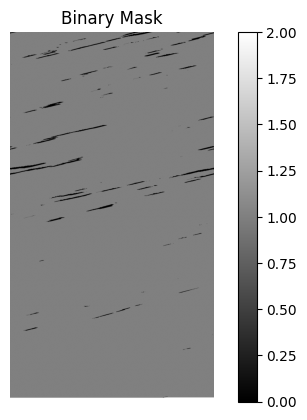

In [28]:
import matplotlib.pyplot as plt
map = results[0]
print(map.shape)
plt.imshow(1 - map, cmap='gray')  # Use 'gray' for binary visualization
plt.colorbar()
plt.title('Binary Mask')
plt.axis('off')
plt.show()

In [ ]:
for score in scores:
    print(score)